In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
WORKDIR = os.getcwd()

Locations Mean AQI
Mandir Marg, Delhi - DPCC=164.85
Chandni Chowk, Delhi - IITM=216.57142857142858
Loni, Ghaziabad - UPPCB=269.0


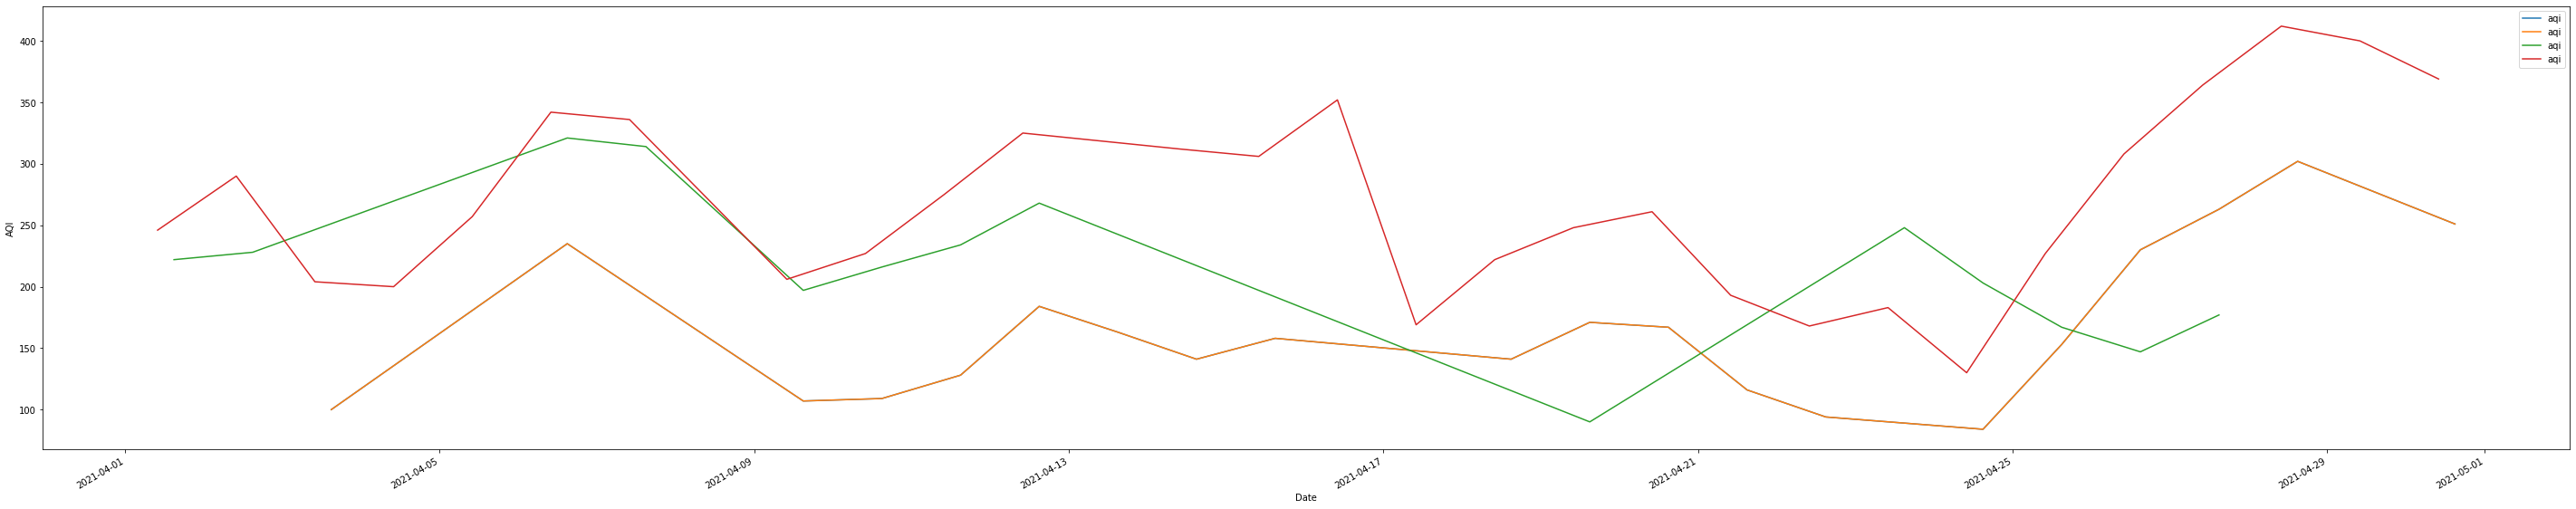

In [2]:
# Reading air quality sensor data obtained from CPCB platform.

import pandas as pd

# Locations where CPCB air quality sensors are present and are collecting ground truth data

locations = [
    'Mandir Marg, Delhi - DPCC',
    'Chandni Chowk, Delhi - IITM',    
    'Loni, Ghaziabad - UPPCB'
]

aq_sensor_data = pd.read_excel(WORKDIR+'/datasets/aqi_sensor_data.xlsx', header=0)  
aq_sensor_data['datetime'] = pd.to_datetime(aq_sensor_data['datetime'], format='%A, %d %b %Y %I:%M %p')
print('Locations Mean AQI')
ax = aq_sensor_data[aq_sensor_data['name']==locations[0]].plot(
    x='datetime', 
    y='aqi', 
    figsize=(50, 10),
    legend=True
)
for i in range(0, len(locations)):
    print(locations[i]+"="+str(aq_sensor_data[aq_sensor_data['name']==locations[i]]['aqi'].mean()))
    aq_sensor_data[aq_sensor_data['name']==locations[i]].plot(
        x='datetime',         
        xlabel='Date',
        ylabel='AQI',
        figsize=(50, 10), 
        legend=True,
        ax=ax)

In [3]:
# Observations from the data

# Delhi lockdown dates in 2021 from April 19 onwards
# https://www.thehindu.com/news/cities/Delhi/delhi-lockdown-extended-till-may-31/article34625962.ece

# The above collected data is for the month of April 2021 for three stations.

# The highest mean AQI is for the location of Loni, Ghaziabad region.
# In Chandni Chowk we observe a sharp decrease in the AQI from 19th April 2021.
# In Mandir Marg, we observe a sharp decrease in 22nd April and then it rises back again.
# In Loni Ghaziabad, we observe higher AQI levels even in the lockdown period.

In [4]:
# Air quality sensor locations of the three ground stations

import geopandas as gpd
gdf = gpd.read_file(WORKDIR+'/datasets/aq_stations.geojson')
gdf.head()

,id,name,geometry
0,1,"Mandir Marg, Delhi - DPCC",POINT (77.20106 28.63643)
1,2,"Chandni Chowk, Delhi - IITM",POINT (77.22723 28.65676)
2,3,"Loni, Ghaziabad - UPPCB",POINT (77.27879 28.75729)


<AxesSubplot:>

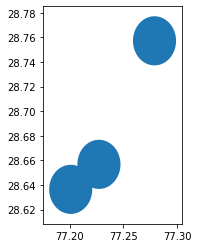

In [5]:
# Region of interest: Buffer of 0.02 degrees is taken around the ground sensors.
# Assumption: Near things affect more than distant things.

gdf['geometry'] = gdf['geometry']
gdf['geometry'] = gdf['geometry'].buffer(0.02)

gdf.plot()

In [6]:
# Mobility can be one of the factors for increase in the AQI levels.
# So one of the parameters can be density of railways and roadways.
# Fetching Highways and Railways Data

hr_gpd = gpd.read_file(WORKDIR+'/datasets/highways_railways.geojson')

In [7]:
#Computing highway and railway line density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]    
    road_density = hr_gpd['geometry'].intersection(a1['geometry']).length
    print('Road Density Values')
    print(a1['name']+'='+str(road_density.sum()))


Road Density Values
Mandir Marg, Delhi - DPCC=2.483152797382156
Road Density Values
Chandni Chowk, Delhi - IITM=2.266370100077988
Road Density Values
Loni, Ghaziabad - UPPCB=0.07730455236204287


In [8]:
# Observations from the Road Density Values

# Mandir Marg has the maximum highway and railway density in the region.
# Loni, Ghaziabad has the least highway and railway density in the region.

In [9]:
# Forest cover is another important indicator for AQI levels.
# Loading Forest Layer

for_gpd = gpd.read_file(WORKDIR+'/datasets/forests.geojson')
for_gpd['geometry'] = for_gpd['geometry'].buffer(0)

In [10]:
#Computing Forest density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]
    forest_density = for_gpd['geometry'].intersection(a1['geometry']).area
    print('Forest density')
    print(a1['name']+'='+str(forest_density.sum()))

Forest density
Mandir Marg, Delhi - DPCC=0.00024191357230874682
Forest density
Chandni Chowk, Delhi - IITM=3.0886444917354208e-06
Forest density
Loni, Ghaziabad - UPPCB=0.0


In [11]:
# Observations from the Forest Density Analysis

# Mandir Marg has the highest forest density cover.
# Loni Ghaziabad has the least forest density cover.

In [12]:
# Industries are another important indicator for the AQI levels.
# Density of industries is another parameter for the analysis.
# Loading Industries Layer

ind_gpd = gpd.read_file(WORKDIR+'/datasets/industrial.geojson')
ind_gpd['geometry'] = ind_gpd['geometry'].buffer(0)

In [13]:
#Computing Industrial density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]
    print('Industry density')
    ind_density = ind_gpd['geometry'].intersection(a1['geometry']).area
    print(a1['name']+'='+str(ind_density.sum()))

Industry density
Mandir Marg, Delhi - DPCC=2.64257285501008e-06
Industry density
Chandni Chowk, Delhi - IITM=0.0
Industry density
Loni, Ghaziabad - UPPCB=0.0


In [14]:
# Observations from the industries layer

# Mandir marg has highest density of industries among the other two regions.

In [34]:
# Loading aerosol data and the distance arrays

from osgeo import gdal_array
import numpy as np

dataset = pd.DataFrame()

aerosolArray = np.array(gdal_array.LoadFile(WORKDIR+'/datasets/aerosol_layer.tif'))
dataset['aerosol'] = np.ndarray.flatten(aerosolArray)

dist_forest = np.array(gdal_array.LoadFile(WORKDIR+'/datasets/dist_from_forests.tif'))
dataset['dforest'] = np.ndarray.flatten(dist_forest)

dist_highways = np.array(gdal_array.LoadFile(WORKDIR+'/datasets/dist_from_highways.tif'))
dataset['dhighways'] = np.ndarray.flatten(dist_highways)

dist_industries = np.array(gdal_array.LoadFile(WORKDIR+'/datasets/dist_from_industries.tif'))
dataset['dindustries'] = np.ndarray.flatten(dist_industries)

dataset = dataset[dataset['aerosol']>aerosolArray.min()]

#Finding Correlation between the proximity from different features and aerosol levels.

print('Aerosol-Proximity from Forests: ',dataset['aerosol'].corr(dataset['dforest'], method='pearson'))
print('Aerosol-Proximity from Highways: ',dataset['aerosol'].corr(dataset['dhighways'], method='pearson'))
print('Aerosol-Proximity from Industries: ',dataset['aerosol'].corr(dataset['dindustries'], method='pearson'))

Aerosol-Proximity from Forests:  0.011710668910335304
Aerosol-Proximity from Highways:  0.0051661418193077145
Aerosol-Proximity from Industries:  0.009112279248524582


In [35]:
# Observations

# The pearson correlation between aerosol and distance from forests is the highest. This
# indicates that there is a positive and stronger linear relationship between aerosol 
# levels and proximity of forests than with industries and highways.